<a href="https://colab.research.google.com/github/sjana01/DeepLearning-and-NeuralNetwork/blob/master/FakeNewsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News Classifier Using LSTM

##Getting the Data

In [1]:
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/fake-news/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/fake-news/test.csv")

In [2]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
train = train.dropna()
test = test.dropna()

In [4]:
X_train = train.drop(['label'], axis=1)
X_test = test

y_train = train['label']

In [5]:
X_train.shape, y_train.shape 

((18285, 4), (18285,))

In [6]:
voc_size = 5000

##Onehot Representation

In [7]:
from tensorflow import keras
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot, text_to_word_sequence

import nltk,re
from nltk.corpus import stopwords

In [8]:
messages = X_train.copy()
messages.reset_index(inplace=True)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
#Data Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus_title = []
for i in range(0,len(messages)):
  review = re.sub("[^a-zA-Z]", " ", messages['title'][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus_title.append(review)

In [11]:
onehot_title = [one_hot(words, voc_size) for words in corpus_title]
onehot_title[0]

[2119, 3222, 643, 2237, 2302, 4169, 4921, 1002, 1448, 4137]

In [12]:
text_to_word_sequence(messages['title'][0])

['house',
 'dem',
 'aide',
 'we',
 'didn’t',
 'even',
 'see',
 'comey’s',
 'letter',
 'until',
 'jason',
 'chaffetz',
 'tweeted',
 'it']

In [13]:
onehot_text = [one_hot(messages['text'][i], voc_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') for i in range(0, len(messages))]

##Embedding Representation (with only title)

In [14]:
sent_length = 20
embedded_title = pad_sequences(onehot_title, padding="post", maxlen=sent_length)

In [15]:
#creating model
emb_vec_features = 40
model = Sequential()
model.add(Embedding(voc_size, emb_vec_features, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
import numpy as np
X_title = np.array(embedded_title)
y_title = np.array(y_train)

In [17]:
X_title.shape, y_title.shape

((18285, 20), (18285,))

##Model Training

In [18]:
model.fit(X_title, y_title, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
229/229 [==============================] - 8s 9ms/step - loss: 0.2854 - accuracy: 0.8622 - val_loss: 0.1932 - val_accuracy: 0.9237
Epoch 2/10
229/229 [==============================] - 1s 7ms/step - loss: 0.1379 - accuracy: 0.9498 - val_loss: 0.1947 - val_accuracy: 0.9223
Epoch 3/10
229/229 [==============================] - 2s 7ms/step - loss: 0.1055 - accuracy: 0.9623 - val_loss: 0.2143 - val_accuracy: 0.9139
Epoch 4/10
229/229 [==============================] - 1s 6ms/step - loss: 0.0823 - accuracy: 0.9706 - val_loss: 0.2435 - val_accuracy: 0.9221
Epoch 5/10
229/229 [==============================] - 1s 6ms/step - loss: 0.0615 - accuracy: 0.9774 - val_loss: 0.2872 - val_accuracy: 0.9139
Epoch 6/10
229/229 [==============================] - 1s 6ms/step - loss: 0.0483 - accuracy: 0.9837 - val_loss: 0.3114 - val_accuracy: 0.9106
Epoch 7/10
229/229 [==============================] - 2s 7ms/step - loss: 0.0356 - accuracy: 0.9889 - val_loss: 0.3113 - val_accuracy: 0.9226
Epoch 

We are getting **99.4**% training accuracy on and **92.2**% validation accuracy on the best epoch.  

##Adding Dropout Layers

In [19]:
from keras.layers import Dropout
##creating model with dropout
emb_vec_features = 40
model = Sequential()
model.add(Embedding(voc_size, emb_vec_features, input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model.fit(X_title, y_title, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
229/229 [==============================] - 4s 9ms/step - loss: 0.2975 - accuracy: 0.8584 - val_loss: 0.1909 - val_accuracy: 0.9232
Epoch 2/10
229/229 [==============================] - 2s 7ms/step - loss: 0.1432 - accuracy: 0.9459 - val_loss: 0.1912 - val_accuracy: 0.9286
Epoch 3/10
229/229 [==============================] - 2s 7ms/step - loss: 0.1047 - accuracy: 0.9599 - val_loss: 0.2183 - val_accuracy: 0.9229
Epoch 4/10
229/229 [==============================] - 2s 7ms/step - loss: 0.0844 - accuracy: 0.9709 - val_loss: 0.2279 - val_accuracy: 0.9262
Epoch 5/10
229/229 [==============================] - 2s 10ms/step - loss: 0.0652 - accuracy: 0.9774 - val_loss: 0.2638 - val_accuracy: 0.9188
Epoch 6/10
229/229 [==============================] - 2s 8ms/step - loss: 0.0532 - accuracy: 0.9817 - val_loss: 0.2375 - val_accuracy: 0.9199
Epoch 7/10
229/229 [==============================] - 2s 7ms/step - loss: 0.0420 - accuracy: 0.9857 - val_loss: 0.2738 - val_accuracy: 0.9212
Epoch

By adding dropout layers we get **92.86**% validation accuracy on best epoch.

##Embedding Representation (with text)

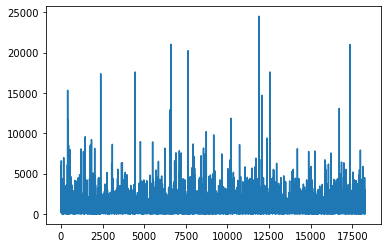

In [21]:
import matplotlib.pyplot as plt

plt.plot([len(x) for x in onehot_text])


In [22]:
text_length = 25000
embedded_text = pad_sequences(onehot_text, padding="post", maxlen=text_length)

In [26]:
#creating model
emb_vec_features = 50
model = Sequential()
model.add(Embedding(voc_size, emb_vec_features, input_length=text_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25000, 50)         250000    
                                                                 
 dropout_5 (Dropout)         (None, 25000, 50)         0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
X_text = np.array(embedded_text)
y_text = np.array(y_train)

In [31]:
##model.fit(X_text, y_text, validation_split=0.2, epochs=10, batch_size=64)  

##need to remove stopwords before traing otherwise will not get good accuracy. removing stopwords with keras is not possible right now, have to use NLTK and will take a long long time!!!